

# Tune Practice

## *Data Science Unit 4 Sprint 2 Assignment 3*

# Gridsearch Hyperparameters

In the guided project, you learned how to use sklearn's GridsearchCV and keras-tuner library to tune the hyperparamters of a neural network model. For your module project you'll continue using these two libraries however we are going to make things a little more interesting for you. 

Continue to use TensorFlow Keras & a sample of the [Quickdraw dataset](https://github.com/googlecreativelab/quickdraw-dataset) to build a sketch classification model. The dataset has been sampled to only 10 classes and 10000 observations per class. 



**Don't forgot to switch to GPU on Colab!**

In [2]:
! pip install -q -U keras-tuner

     |████████████████████████████████| 71kB 4.8MB/s 


In [6]:
import tensorflow
tensorflow.__version__

'2.5.0'

In [69]:
# native python libraries imports 
import math
from time import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# sklearn imports 
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

# keras imports 
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from kerastuner.tuners import RandomSearch, BayesianOptimization, Sklearn
from kerastuner.engine.hyperparameters import HyperParameters
from tensorflow.keras.activations import relu, sigmoid
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.utils import get_file

# required for compatibility between sklearn and keras
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

In [70]:
def load_quickdraw10():
    """
    Fill out this doc string, and comment the code, for practice in writing the kind of code that will get you hired. 
    """
    
    URL_ = "https://github.com/LambdaSchool/DS-Unit-4-Sprint-2-Neural-Networks/blob/main/quickdraw10.npz?raw=true"
    
    path_to_zip = get_file('./quickdraw10.npz', origin=URL_, extract=False)

    data = np.load(path_to_zip)
    
    # normalize your image data
    max_pixel_value = 255
    X = data['arr_0']/max_pixel_value
    Y = data['arr_1']
        
    return train_test_split(X, Y, shuffle=True)

In [72]:
X_train, X_test, y_train, y_test = load_quickdraw10()

In [73]:
X_train.shape

(75000, 784)

In [74]:
y_train.shape

(75000,)

_____

# Experiment 1

## Tune Hyperperameters using Enhanced GridsearchCV 

We are going to use GridsearchCV again to tune a deep learning model however we are going to add some additional functionality to our gridsearch. Specifically, we are going to automate away the generation of how many nodes to use in a layer and how many layers to use in a model! 

By the way, yes, there is a function within a function. Try to not let that bother you. An alternative to this would be to create a class. If you're up for the challenge give it a shot. However, consider this a stretch goal that you come back to after you finish going through this assignment. 


### Objective 

The objective of this experiment is to show you how to automate the generation of layers and layer nodes for the purposes of gridsearch. Up until now, we've been manually selecting the number of layers and layer nodes.

In [14]:
# Function to create model, required for KerasClassifier
def create_model(n_layers,  first_layer_nodes, last_layer_nodes, act_funct ="relu", negative_node_incrementation=True):
    """"
    Returns a complied keras model 
    
    Parameters
    ----------
    n_layers: int 
        number of hidden layers in model 
        To be clear, this excludes the input and output layer.
        
    first_layer_nodes: int
        Number of nodes in the first hidden layer 

    last_layer_nodes: int
        Number of nodes in the last hidden layer (this is the layer just prior to the output layer)
        
     act_funct: string 
         Name of activation function to use in hidden layers (this excludes the output layler)
        
    Returns
    -------
    model: keras object 
    """
    
    def gen_layer_nodes(n_layers, first_layer_nodes, last_layer_nodes, negative_node_incrementation=True):
        """
        Generates and returns the number of nodes in each hidden layer. 
        To be clear, this excludes the input and output layer. 

        Note
        ----
        Number of nodes in each layer is linearly incremented. 
        For example, gen_layer_nodes(5, 500, 100) will generate [500, 400, 300, 200, 100]

        Parameters
        ----------
        n_layers: int
            Number of hidden layers
            This values should be 2 or greater 

        first_layer_nodes: int

        last_layer_nodes: int

        Returns
        -------
        layers: list of ints
            Contains number of nodes for each layer 
        """

        # throws an error if n_layers is less than 2 
        assert n_layers >= 2, "n_layers must be 2 or greater"

        layers = []

        # PROTIP: IF YOU WANT THE NODE INCREMENTATION TO BE SPACED DIFFERENTLY
        # THEN YOU'LL NEED TO CHANGE THE WAY THAT IT'S CALCULATED - HAVE FUN!
        # when set to True number of nodes are decreased for subsequent layers 
        if negative_node_incrementation:
            # subtract this amount from previous layer's nodes in order to increment towards smaller numbers 
            nodes_increment = (last_layer_nodes - first_layer_nodes)/ (n_layers-1)
            
        # when set to False number of nodes are increased for subsequent layers
        else:
            # add this amount from previous layer's nodes in order to increment towards larger numbers 
            nodes_increment = (first_layer_nodes - last_layer_nodes)/ (n_layers-1)

        nodes = first_layer_nodes

        for i in range(1, n_layers+1):

            layers.append(math.ceil(nodes))

            # increment nodes for next layer 
            nodes = nodes + nodes_increment

        return layers
    
    # create model
    model = Sequential()
    
    n_nodes = gen_layer_nodes(n_layers, first_layer_nodes, last_layer_nodes, negative_node_incrementation)
    
    for i in range(1, n_layers):
        if i==1:
            model.add(Dense(first_layer_nodes, input_dim=X_train.shape[1], activation=act_funct))
        else:
            model.add(Dense(n_nodes[i-1], activation=act_funct))
            
            
    # output layer 
    model.add(Dense(10, # 10 unit/neurons in output layer because we have 10 possible labels to predict  
                    activation='softmax')) # use softmax for a label set greater than 2            
    
    # Compile model
    model.compile(loss='sparse_categorical_crossentropy', 
                  optimizer='adam', # adam is a good default optimizer 
                  metrics=['accuracy'])
    
    # do not include model.fit() inside the create_model function
    # KerasClassifier is expecting a complied model 
    return model


## Explore create_model

Let's build a few different models in order to understand how the above code works in practice. 

### Build model 

Use `create_model` to build a model. 

- Set `n_layers = 10` 
- Set `first_layer_nodes = 500`
- Set `last_layer_nodes = 100`
- Set `act_funct = "relu"`
- Make sure that `negative_node_incrementation = True`

In [15]:
# use create_model to create a model 

# instantiate the model
model = create_model(n_layers=10, first_layer_nodes=500, last_layer_nodes=100, act_funct='relu', negative_node_incrementation=True)

In [16]:
# run model.summary() and make sure that you understand the model architecture that you just built 
# Notice in the model summary how the number of nodes have been linearly incremented in decreasing values. 
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 500)               392500    
_________________________________________________________________
dense_1 (Dense)              (None, 456)               228456    
_________________________________________________________________
dense_2 (Dense)              (None, 412)               188284    
_________________________________________________________________
dense_3 (Dense)              (None, 367)               151571    
_________________________________________________________________
dense_4 (Dense)              (None, 323)               118864    
_________________________________________________________________
dense_5 (Dense)              (None, 278)               90072     
_________________________________________________________________
dense_6 (Dense)              (None, 234)               6

### Build model 

Use `create_model` to build a model. 

- Set `n_layers = 10` 
- Set `first_layer_nodes = 500`
- Set `last_layer_nodes = 100`
- Set `act_funct = "relu"`
- Make sure that `negative_node_incrementation = False`

In [19]:
# use create_model to create a model 

# instantiate the model
model = create_model(n_layers=10, first_layer_nodes=500, last_layer_nodes=100, act_funct='relu', negative_node_incrementation=False)

In [20]:
# run model.summary() and make sure that you understand the model architecture that you just built 
# Notice in the model summary how the number of nodes have been linearly incremented in increasing values.
# The output layer must have 10 nodes because there are 10 labels to predict 
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 500)               392500    
_________________________________________________________________
dense_21 (Dense)             (None, 545)               273045    
_________________________________________________________________
dense_22 (Dense)             (None, 589)               321594    
_________________________________________________________________
dense_23 (Dense)             (None, 634)               374060    
_________________________________________________________________
dense_24 (Dense)             (None, 678)               430530    
_________________________________________________________________
dense_25 (Dense)             (None, 723)               490917    
_________________________________________________________________
dense_26 (Dense)             (None, 767)              

In [ ]:
# feel free to play around with parameters to gain additional insight as to how the create_model function works 



Ok, now that we've played around a bit with  `create_model` in order to understand how it works, let's build a much simpler model that we'll be running gridsearches. 

### Build model 

Use `create_model` to build a model. 

- Set `n_layers = 2` 
- Set `first_layer_nodes = 500`
- Set `last_layer_nodes = 100`
- Set `act_funct = "relu"`
- Make sure that `negative_node_incrementation = True`

In [21]:
# use create_model to create a model 

# instantiate the model
model = create_model(n_layers=2, first_layer_nodes=500, last_layer_nodes=100, act_funct='relu', negative_node_incrementation=True)

In [22]:
# run model.summary() and make sure that you understand the model architecture that you just built 
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_30 (Dense)             (None, 500)               392500    
_________________________________________________________________
dense_31 (Dense)             (None, 10)                5010      
Total params: 397,510
Trainable params: 397,510
Non-trainable params: 0
_________________________________________________________________


In [23]:
# define the grid search parameters
param_grid = {'n_layers': [2, 3],
              'epochs': [3], 
              "first_layer_nodes": [500, 300],
              "last_layer_nodes": [100, 50]
             }

In [24]:
model = KerasClassifier(create_model)

In [25]:
# Create Grid Search
grid = GridSearchCV(estimator=model, 
                    param_grid=param_grid, 
                    n_jobs=-2, 
                    verbose=1, 
                    cv=3)

grid_result = grid.fit(X_train, y_train)

# Report Results
print(f"Best: {grid_result.best_score_} using {grid_result.best_params_}")

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print(f"Means: {mean}, Stdev: {stdev} with: {param}")

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-2)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/3
1563/1563 [==============================] - 16s 2ms/step - loss: 0.8503 - accuracy: 0.7378
Epoch 2/3
1563/1563 [==============================] - 3s 2ms/step - loss: 0.4647 - accuracy: 0.8639
Epoch 3/3
782/782 [==============================] - 2s 2ms/step - loss: 0.4708 - accuracy: 0.8634
Epoch 1/3
1563/1563 [==============================] - 4s 2ms/step - loss: 0.8239 - accuracy: 0.7490
Epoch 2/3
1563/1563 [==============================] - 3s 2ms/step - loss: 0.4529 - accuracy: 0.8673
Epoch 3/3
782/782 [==============================] - 1s 2ms/step - loss: 0.4599 - accuracy: 0.8662
Epoch 1/3
1563/1563 [==============================] - 4s 2ms/step - loss: 0.8158 - accuracy: 0.7566
Epoch 2/3
1563/1563 [==============================] - 3s 2ms/step - loss: 0.4531 - accuracy: 0.8637
Epoch 3/3
782/782 [==============================] - 1s 2ms/step - loss: 0.4760 - accuracy: 0.8637
Epoch 1/3
1563/1563 [==============================] - 4s 2ms/step - loss: 0.8083 - accuracy: 0.

[Parallel(n_jobs=-2)]: Done  24 out of  24 | elapsed:  6.2min finished


2344/2344 [==============================] - 5s 2ms/step - loss: 0.7699 - accuracy: 0.7687
Epoch 2/3
2344/2344 [==============================] - 5s 2ms/step - loss: 0.4274 - accuracy: 0.8719
Epoch 3/3
2344/2344 [==============================] - 5s 2ms/step - loss: 0.3449 - accuracy: 0.8958
Best: 0.8674533367156982 using {'epochs': 3, 'first_layer_nodes': 500, 'last_layer_nodes': 50, 'n_layers': 2}
Means: 0.864413321018219, Stdev: 0.0012700890703041857 with: {'epochs': 3, 'first_layer_nodes': 500, 'last_layer_nodes': 100, 'n_layers': 2}
Means: 0.8669999837875366, Stdev: 0.0014055218196194698 with: {'epochs': 3, 'first_layer_nodes': 500, 'last_layer_nodes': 100, 'n_layers': 3}
Means: 0.8674533367156982, Stdev: 0.0016883555271377036 with: {'epochs': 3, 'first_layer_nodes': 500, 'last_layer_nodes': 50, 'n_layers': 2}
Means: 0.8581599990526835, Stdev: 0.008793876239709262 with: {'epochs': 3, 'first_layer_nodes': 500, 'last_layer_nodes': 50, 'n_layers': 3}
Means: 0.8582666714986166, Stdev:

In [26]:
best_model = grid_result.best_estimator_

In [27]:
best_model.get_params()

{'build_fn': <function __main__.create_model>,
 'epochs': 3,
 'first_layer_nodes': 500,
 'last_layer_nodes': 50,
 'n_layers': 2}

-----

# Experiment 2

## Benchmark different Optimization Algorithms 

In this section, we are going to use the same model and dataset in order to benchmark 3 different gridsearch approaches: 

- Random Search
- Bayesian Optimization. 
- Brute Force Gridsearch

Our goal in this experiment is two-fold. We want to see which appraoch 

- Scores the highest accuracy
- Has the shortest run time 

We want to see how these 3 gridsearch approaches handle these trade-offs and to give you a sense of those trades offs.

### Trade-offs

`Brute Force Gridsearch` will train a model on every single unique hyperparameter combination, this guarantees that you'll get the highest possible accuracy from your parameter set but your gridsearch might have a very long run-time. 

`Random Search` will randomly sample from your parameter set which, depending on how many samples, the run-time might be significantly cut down but you might or might not sample the parameters that correspond to the heightest possible accuracies. 

`Bayesian Optimization` has a bit of intelligence built into it's search algorithm but you do need to manually select some parameters which greatly influence the model learning outcomes. 

-------
### Build our model

In [28]:
# because gridsearching can take a lot of time and we are bench marking 3 different approaches
# let's build a simple model to minimize run time 

def build_model(hp):
    
    """
    Returns a complied keras model ready for keras-tuner gridsearch algorithms 
    """
    
    model = Sequential()
    
    # hidden layer
    model.add(Dense(units=hp.get('units'),activation=hp.get("activation")))
    
    # output layer
    model.add(Dense(10, activation='softmax'))
    
    model.compile(
        optimizer=keras.optimizers.Adam(hp.get('learning_rate')),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy'])
    
    return model
  

In [29]:
# build out our hyperparameter dictionary 
hp = HyperParameters()
hp.Int('units', min_value=32, max_value=512, step=32)
hp.Choice('learning_rate',values=[1e-1, 1e-2, 1e-3])
hp.Choice('activation',values=["relu", "sigmoid"])

'relu'

------
# Run the Gridsearch Algorithms 

### Random Search

Be sure to check out the [**docs for Keras-Tuner**](https://keras-team.github.io/keras-tuner/documentation/tuners/). Here you can read about the input parameters for the `RandomSearch` tuner.

In [31]:
# how many unique hyperparameter combinations do we have? 
# HINT: take the product of the number of possible values for each hyperparameter 
# save your answer to n_unique_hparam_combos

# YOUR CODE HERE
n_unique_hparam_combos = 16*3*2
n_unique_hparam_combos

96

In [35]:
# how many of these do we want to randomly sample?
# let's pick 25% of n_unique_hparam_combos param combos to sample
# save this number to n_param_combos_to_sample

# YOUR CODE HERE
n_param_combos_to_sample = int(0.25 * n_unique_hparam_combos)
n_param_combos_to_sample

24

In [39]:
random_tuner = RandomSearch(
            build_model,
            objective='val_accuracy',
            max_trials=n_param_combos_to_sample, # number of times to sample the parameter set and build a model 
            seed=1234,
            hyperparameters=hp, # pass in our hyperparameter dictionary
            directory='./keras-tuner-trial',
            project_name='random_search')

In [40]:
# take note of Total elapsed time in print out
random_tuner.search(X_train, y_train,
                    epochs=3,
                    validation_data=(X_test, y_test))

Trial 24 Complete [00h 00m 20s]
val_accuracy: 0.6822800040245056

Best val_accuracy So Far: 0.8733599781990051
Total elapsed time: 00h 07m 44s
INFO:tensorflow:Oracle triggered exit


In [41]:
# identify the best score and hyperparamter (should be at the top since scores are ranked)
random_tuner.results_summary()

Results summary
Results in ./keras-tuner-trial/random_search
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
units: 352
learning_rate: 0.001
activation: relu
Score: 0.8733599781990051
Trial summary
Hyperparameters:
units: 384
learning_rate: 0.001
activation: relu
Score: 0.8731200098991394
Trial summary
Hyperparameters:
units: 448
learning_rate: 0.001
activation: sigmoid
Score: 0.8675199747085571
Trial summary
Hyperparameters:
units: 416
learning_rate: 0.001
activation: sigmoid
Score: 0.8656399846076965
Trial summary
Hyperparameters:
units: 480
learning_rate: 0.001
activation: sigmoid
Score: 0.8638399839401245
Trial summary
Hyperparameters:
units: 288
learning_rate: 0.001
activation: sigmoid
Score: 0.8600800037384033
Trial summary
Hyperparameters:
units: 224
learning_rate: 0.001
activation: sigmoid
Score: 0.8557999730110168
Trial summary
Hyperparameters:
units: 320
learning_rate: 0.01
activation: sigmoid
Score: 0.841480016708374
Tria

 ### Results
 
Identify and write the the best performing hyperparamter combination and model score. 
Note that because this is Random Search, multiple runs might have slighly different outcomes. 
 
 

## Answer:

The best score from the random search run was with the following parameters:-
```
Trial summary
Hyperparameters:
units: 352
learning_rate: 0.001
activation: relu
```

The score stood at: 
Score: 0.8733599781990051


------
### Bayesian Optimization

![](https://upload.wikimedia.org/wikipedia/commons/0/02/GpParBayesAnimationSmall.gif)

Be sure to check out the [**docs for Keras-Tuner**](https://keras-team.github.io/keras-tuner/documentation/tuners/). Here you can read about the input parameters for the `BayesianOptimization` tuner.

Pay special attention to these `BayesianOptimization` parameters: `num_initial_points` and `beta`. 

`num_initial_points`: 

Number of randomly selected hyperparameter combinations to try before applying bayesian probability to determine liklihood of which param combo to try next based on expected improvement


`beta`: 

Larger values means more willing to explore new hyperparameter combinations (analogous to searching for the global minimum in Gradient Descent), smaller values means that it is less willing to try new hyperparameter combinations (analogous to getting stuck in a local minimum in Gradient Descent). 

As a start, error on the side of larger values. What defines a small or large value you ask? That question would pull us into the mathematical intricacies of Bayesian Optimization and Gaussian Processes. For simplicity, notice that the default value is 2.6 and work from there. 

In [98]:
# we know that 24 samples is about 25% of 96 possible hyper-parameter combos
# because BO isn't random (after num_initial_points number of trails) let's see if 15 max trials gives good results
# feel free to play with any of these numbers
max_trials=15
num_initial_points=5
beta=5.0

In [43]:
bayesian_tuner = BayesianOptimization(
                    build_model,
                    objective='val_accuracy',
                    max_trials=max_trials,
                    hyperparameters=hp, # pass in our hyperparameter dictionary
                    num_initial_points=num_initial_points, 
                    beta=beta, 
                    seed=1234,
                    directory='./keras-tuner-trial',
                    project_name='bayesian_optimization_4')

In [44]:
bayesian_tuner.search(X_train, y_train,
               epochs=3,
               validation_data=(X_test, y_test))

Trial 15 Complete [00h 00m 17s]
val_accuracy: 0.8263999819755554

Best val_accuracy So Far: 0.8768799901008606
Total elapsed time: 00h 04m 54s
INFO:tensorflow:Oracle triggered exit


In [54]:
bayesian_tuner.results_summary()

Results summary
Results in ./keras-tuner-trial/bayesian_optimization_4
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
units: 512
learning_rate: 0.001
activation: relu
Score: 0.8768799901008606
Trial summary
Hyperparameters:
units: 352
learning_rate: 0.001
activation: relu
Score: 0.8698400259017944
Trial summary
Hyperparameters:
units: 480
learning_rate: 0.001
activation: sigmoid
Score: 0.8691200017929077
Trial summary
Hyperparameters:
units: 256
learning_rate: 0.001
activation: sigmoid
Score: 0.8633999824523926
Trial summary
Hyperparameters:
units: 256
learning_rate: 0.01
activation: sigmoid
Score: 0.840399980545044
Trial summary
Hyperparameters:
units: 32
learning_rate: 0.001
activation: relu
Score: 0.8281199932098389
Trial summary
Hyperparameters:
units: 32
learning_rate: 0.001
activation: relu
Score: 0.8268399834632874
Trial summary
Hyperparameters:
units: 32
learning_rate: 0.001
activation: relu
Score: 0.8263999819755554
Trial 

 ### Results
 
Identify and write the the best performing hyperparamter combination and model score. 
Note that because this is  Bayesian Optimization, multiple runs might have slighly different outcomes. 
 
 


---


## Answer:

The best score from the random search run was with the following parameters:-
```
Trial summary
Hyperparameters:
units: 352
learning_rate: 0.001
activation: relu
```

The score stood at: 
Score: 0.8768799901008606

This score was marginally higher compared with the results from random search. Although the time taken using the Bayseian search was half compared with the random search. 



---



---------
## Brute Force Gridsearch Optimization


### Populate a Sklearn compatiable parameter dictionary

In [45]:
# build out our hyperparameter dictionary 
hyper_parameters = {
    # BUG Fix: cast array as list otherwise GridSearchCV will throw error
    "units": np.arange(32, 544, 32).tolist(),
    "learning_rate": [1e-1, 1e-2, 1e-3],
    "activation":["relu", "sigmoid"]
}

In [46]:
hyper_parameters

{'activation': ['relu', 'sigmoid'],
 'learning_rate': [0.1, 0.01, 0.001],
 'units': [32,
  64,
  96,
  128,
  160,
  192,
  224,
  256,
  288,
  320,
  352,
  384,
  416,
  448,
  480,
  512]}

### Build a Sklearn compatiable model function

In [47]:
def build_model(units, learning_rate, activation):
    
    """
    Returns a complie keras model ready for keras-tuner gridsearch algorithms 
    """
    
    model = Sequential()
    
    # hidden layer
    model.add(Dense(units, activation=activation))
    
    # output layer
    model.add(Dense(10, activation='softmax'))
    
    model.compile(
        optimizer=Adam(learning_rate),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy'])
    
    return model

In [48]:
model = KerasClassifier(build_fn = build_model)

In [49]:
# save start time 
start = time()

# Create Grid Search
grid = GridSearchCV(estimator=model, 
                    param_grid=hyper_parameters, 
                    n_jobs=-2, 
                    verbose=1, 
                    cv=3)

grid_result = grid.fit(X_train, y_train)

# save end time 
end = time()

# Report Results
print(f"Best: {grid_result.best_score_} using {grid_result.best_params_}")

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print(f"Means: {mean}, Stdev: {stdev} with: {param}")

Fitting 3 folds for each of 96 candidates, totalling 288 fits


[Parallel(n_jobs=-2)]: Using backend SequentialBackend with 1 concurrent workers.


782/782 [==============================] - 2s 2ms/step - loss: 0.6760 - accuracy: 0.8002


[Parallel(n_jobs=-2)]: Done 288 out of 288 | elapsed: 32.1min finished


2344/2344 [==============================] - 5s 2ms/step - loss: 0.6196 - accuracy: 0.8156
Best: 0.8429200053215027 using {'activation': 'relu', 'learning_rate': 0.001, 'units': 448}
Means: 0.23656000196933746, Stdev: 0.0574452375669479 with: {'activation': 'relu', 'learning_rate': 0.1, 'units': 32}
Means: 0.2693599959214528, Stdev: 0.03389793652211055 with: {'activation': 'relu', 'learning_rate': 0.1, 'units': 64}
Means: 0.24924000600973764, Stdev: 0.06359286760855748 with: {'activation': 'relu', 'learning_rate': 0.1, 'units': 96}
Means: 0.23649333914120993, Stdev: 0.011923773831071505 with: {'activation': 'relu', 'learning_rate': 0.1, 'units': 128}
Means: 0.2958800097306569, Stdev: 0.02427548366096506 with: {'activation': 'relu', 'learning_rate': 0.1, 'units': 160}
Means: 0.2537600000699361, Stdev: 0.037766400599872886 with: {'activation': 'relu', 'learning_rate': 0.1, 'units': 192}
Means: 0.27643999457359314, Stdev: 0.041954536793173146 with: {'activation': 'relu', 'learning_rate': 

In [50]:
# total run time 
total_run_time_in_miniutes = (end - start)/60
total_run_time_in_miniutes

32.23345305522283

In [51]:
grid_result.best_params_

{'activation': 'relu', 'learning_rate': 0.001, 'units': 448}

In [52]:
# because all other optimization approaches are reporting test set score
# let's calculate the test set score in this case 
best_model = grid_result.best_estimator_
test_acc = best_model.score(X_test, y_test)

782/782 [==============================] - 1s 2ms/step - loss: 0.4941 - accuracy: 0.8531


In [53]:
test_acc

0.8531200289726257

 ### Results
 
Identify and write the the best performing hyperparamter combination and model score. 
 
 

YOUR ANSWER HERE

_______

# Conclusion

The spirit of this experiment is to expose you to the idea of benchmarking and comparing the trade-offs of various gridsearch approaches. 

Even if we did find a way to pass in the original test set into GridSearchCV, we can see that both Random Search and Bayesian Optimization are arguably better alternatives to a brute force grid search when we consider the trade-offs of run time and locating the best performing model. 

----

# Stretch Goals

- Feel free to run whatever gridserach experiments on whatever models you like!

In [ ]:
# this is your open playground - be free to explore as you wish 

## Experimenting with WANDB

In [90]:
%%capture
!pip install wandb -qqq
import wandb
from wandb.keras import WandbCallback

In [76]:
!wandb login

wandb: Currently logged in as: singparvi (use `wandb login --relogin` to force relogin)


In [77]:
# Check the dataset first 
X_train.shape, y_train.shape


((75000, 784), (75000,))

In [78]:
# X_train[0] # This data is already scaled

In [79]:
# set an experiment name to group training and evaluation
experiment_name = wandb.util.generate_id()

# start a run, tracking hyperparameters
wandb.init(
    project='DS-Unit4-quickdraw',
    group=experiment_name,
    config={
        'layer_1': 512,
        'activation_1': 'relu',
        'dropout': 0.2,
        'layer_2': 10,
        'activation_2': 'softmax',
        'optimizer': 'sgd',
        'loss': 'sparse_categorical_crossentropy',
        'metric': 'accuracy',
        'epoch': 6,
        'batch_size': 32
    }
)
config = wandb.config


In [80]:
X_train[::5].shape

(15000, 784)

In [81]:
X_train.shape

(75000, 784)

In [82]:
X_train[::2].shape

(37500, 784)

In [86]:
# build the model
model = Sequential(
    [
     Dense(config.layer_1, activation=config.activation_1),
     tensorflow.keras.layers.Dropout(config.dropout),
     Dense(config.layer_2, activation=config.activation_2)

    ]
)

# compile the model
model.compile(optimizer=config.optimizer,
              loss=config.loss,
              metrics=[config.metric])

In [92]:
history = model.fit(X_train, y_train, 
                    epochs=config.epoch,
                    batch_size=config.batch_size,
                    validation_data=(X_test, y_test),
                    # Use the Wandbcallback to automatically save all the 
                    # metrics tracked in model.fit() to your dashboard
                    callbacks=[WandbCallback()])

wandb.finish()

Epoch 1/6
2344/2344 [==============================] - 7s 3ms/step - loss: 1.0704 - accuracy: 0.6814 - val_loss: 0.8223 - val_accuracy: 0.7658
Epoch 2/6
2344/2344 [==============================] - 6s 3ms/step - loss: 0.8082 - accuracy: 0.7671 - val_loss: 0.7291 - val_accuracy: 0.7923
Epoch 3/6
2344/2344 [==============================] - 6s 2ms/step - loss: 0.7221 - accuracy: 0.7922 - val_loss: 0.6651 - val_accuracy: 0.8132
Epoch 4/6
2344/2344 [==============================] - 6s 2ms/step - loss: 0.6649 - accuracy: 0.8085 - val_loss: 0.6207 - val_accuracy: 0.8230
Epoch 5/6
2344/2344 [==============================] - 6s 3ms/step - loss: 0.6208 - accuracy: 0.8214 - val_loss: 0.5883 - val_accuracy: 0.8322
Epoch 6/6
2344/2344 [==============================] - 6s 3ms/step - loss: 0.5880 - accuracy: 0.8309 - val_loss: 0.5640 - val_accuracy: 0.8376


epoch,5
loss,0.58803
accuracy,0.83089
val_loss,0.56396
val_accuracy,0.8376
_runtime,510
_timestamp,1621993949
_step,5
best_val_loss,0.56396
best_epoch,5


epoch,▁▂▄▅▇█
loss,█▄▃▂▁▁
accuracy,▁▅▆▇██
val_loss,█▅▄▃▂▁
val_accuracy,▁▄▆▇▇█
_runtime,▁▂▄▅▇█
_timestamp,▁▂▄▅▇█
_step,▁▂▄▅▇█


In [95]:
%%capture
# Install dependencies
!pip install scikit-plot -qqq

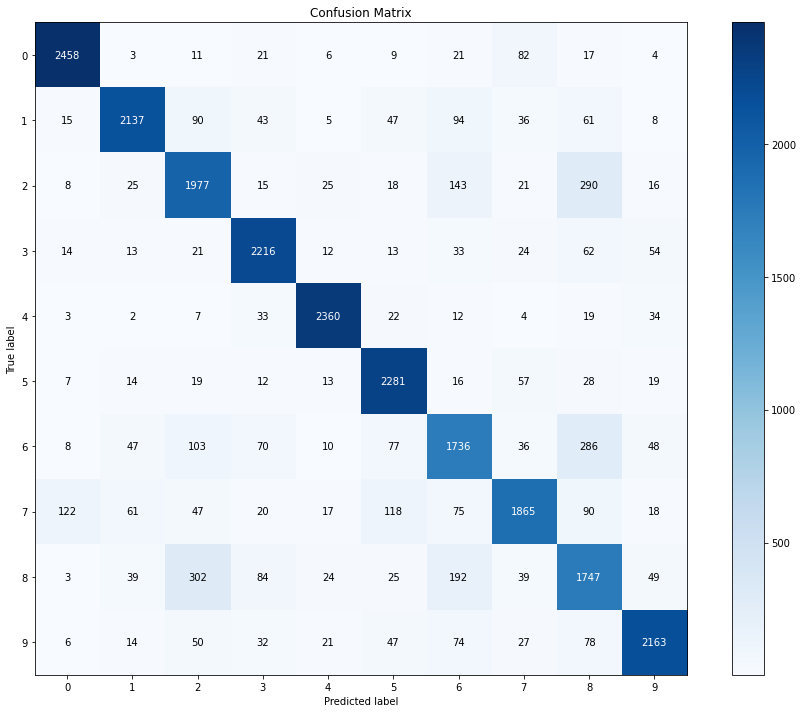

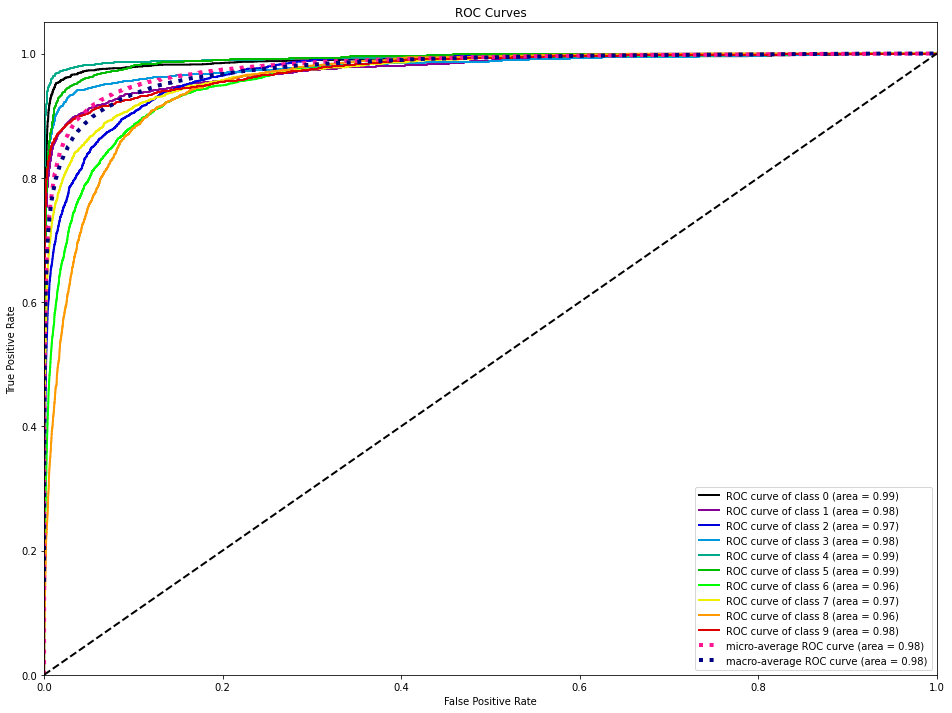

In [97]:
import numpy as np
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
from scikitplot.metrics import plot_confusion_matrix, plot_roc

wandb.init(project="intro-demo", group=experiment_name)

# Log F1 Score
y_test_pred = np.asarray(model.predict(X_test))
y_test_pred_class = np.argmax(y_test_pred, axis=1)
f1 = f1_score(y_test, y_test_pred_class, average='micro')
wandb.log({"f1": f1},
          commit=False)  # Hold on, more incoming!

# Log Confusion Matrix
fig, ax = plt.subplots(figsize=(16, 12))
plot_confusion_matrix(y_test, y_test_pred_class, ax=ax)
wandb.log({"confusion_matrix": wandb.Image(fig)}, commit=False)

# Log ROC Curve
fig, ax = plt.subplots(figsize=(16, 12))
plot_roc(y_test, y_test_pred, ax=ax)
wandb.log({"plot_roc": wandb.Image(fig)},
          commit=True)  # Now we've logged everything for this step

class_score_data = []
for test, pred in zip(y_test, y_test_pred):
    class_score_data.append([test, pred])

wandb.log({"class_scores": wandb.Table(data=class_score_data,
                                           columns=["test", "pred"])})

In [ ]:
tensorflow.keras.layers.Dropout